# Training a simple classifier on CIFAR-10
* We will do the following steps in order:
    1. Load and normalizing the CIFAR10 training and test datasets using torchvision
    2. Define a Convolutional Neural Network
    3. Define a loss function
    4. Train the network on the training data
    5. Test the network on the test data

### Load and normalizing the CIFAR10 training and test datasets using torchvision

In [3]:
# Loading and normalizing CIFAR-10
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

In [6]:
# The output of torchvision datasets are PILImage images of range [0,1].
# Transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose( #transforms 함수 미리 정의
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#위의 normalize는 는 image = (image - mean) / std 를 시켜줌. 3 개인 이유는 각 채널마다 mean, std를 적용시켜야 되기 때문. 
#input value [0,1] -> [-1, 1] range로 바뀜. 예를 들어서, minimum value 0은 (0-0.5)/0.5 = -1, maximum value 1은 (1-0.5)/0.5 = 1 이 된다.

batch_size = 8
#load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, #torchvision의 dataset에서 CIFAR10 dataset다운 받음. 
                                      download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
#define dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


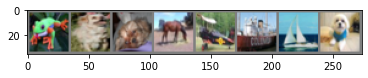

 frog   dog   dog horse plane  ship  ship   dog


In [7]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Define a Convolutional Neural Network
* Network Model
    1. Convolution - input channel: 3, output channel: 6, kernel_size: 5
    2. Maxpoling   - size: 2, stride: 2
    3. Convolution - input channel: 6, output channel: 16, kernel_size: 5
    4. Maxpoling   - size: 2, stride: 2
    5. Fully connected layer - out_channel: 120
    6. Fully connected layer - out_channel: 84
    7. Fully connected layer - out_channel: 10
    
* Note: Apply Rectified Linear Unit(ReLU) for each layer output except last one

In [8]:
# Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F

#computing output spatial dim: (W - F + 2P)/S + 1 where W: input spatial size, F: kernel size, P: padding, S: stride
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) #default stride=1, padding=0
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # input shape: [Batchsize, 3, 32, 32]

        x = F.relu(self.conv1(x)) # [Batchsize, 6, 28, 28]
        x = self.pool(x) # [Batchsize, 6, 14, 14]
        
        x = F.relu(self.conv2(x)) # [Batchsize, 16, 10, 10]
        x = self.pool(x) # [Batchsize, 16, 5, 5]
        
        
        x = x.view(-1, 16 * 5 * 5) # [Batchsize, 16*5*5]
        x = F.relu(self.fc1(x)) # [Batchsize, 120]
        x = F.relu(self.fc2(x)) # [Batchsize, 84]
        x = self.fc3(x) # [Batchsize, 10]
        return x
        
        
net = Net().cuda()

In [9]:
# # for debug
# net_debug = Net()
# input = torch.randn(4, 3, 32, 32)
# output = net_debug(input)


### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use SGD with learning rate 0.0001 and momentum 0.9

In [10]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss에 softmax까지 구현되어있기 때문에 모델에 softmax를 선언하지 않아도 됨. 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network on the training data

In [12]:
### Train the network
print('Start Training ')
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Fill this loop
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print statistics
        if i % 500 == 499:
            print("epoch: {}, iter: {}, loss: {:.3f}".format(epoch+1, i+1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

Start Training 
epoch: 1, iter: 500, loss: 2.293
epoch: 1, iter: 1000, loss: 2.215
epoch: 1, iter: 1500, loss: 2.072
epoch: 1, iter: 2000, loss: 1.966
epoch: 1, iter: 2500, loss: 1.840
epoch: 1, iter: 3000, loss: 1.749
epoch: 1, iter: 3500, loss: 1.705
epoch: 1, iter: 4000, loss: 1.652
epoch: 1, iter: 4500, loss: 1.651
epoch: 1, iter: 5000, loss: 1.604
epoch: 1, iter: 5500, loss: 1.557
epoch: 1, iter: 6000, loss: 1.543
epoch: 2, iter: 500, loss: 1.500
epoch: 2, iter: 1000, loss: 1.512
epoch: 2, iter: 1500, loss: 1.465
epoch: 2, iter: 2000, loss: 1.476
epoch: 2, iter: 2500, loss: 1.439
epoch: 2, iter: 3000, loss: 1.405
epoch: 2, iter: 3500, loss: 1.385
epoch: 2, iter: 4000, loss: 1.387
epoch: 2, iter: 4500, loss: 1.402
epoch: 2, iter: 5000, loss: 1.374
epoch: 2, iter: 5500, loss: 1.348
epoch: 2, iter: 6000, loss: 1.347
Finished Training


### Test the network on the test data

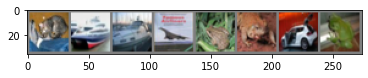

GrondTruth:    cat  ship  ship plane  frog  frog   car  frog


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [14]:
images = images.cuda()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size))) 


Predicted:    cat  ship   car  ship  deer  frog   car  deer


In [15]:
# Let us look at how the network performs on the whole dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 39 %
Accuracy of   car : 71 %
Accuracy of  bird : 43 %
Accuracy of   cat : 29 %
Accuracy of  deer : 57 %
Accuracy of   dog : 43 %
Accuracy of  frog : 61 %
Accuracy of horse : 30 %
Accuracy of  ship : 80 %
Accuracy of truck : 30 %
